# MPPI (Model Predictive Path-Integral) Control

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from matplotlib import patches
from matplotlib.animation import ArtistAnimation
from IPython import display

## Control Target : Pendulum

<img src="../media/pendulum.png" width="500px">

In [2]:
class Pendulum():
    def __init__(
            self,
            mass_of_pole: float = 1.0,
            length_of_pole: float = 1.0,
            max_torque_abs: float = 2.0,
            max_speed_abs: float = 8.0,
            delta_t: float = 0.05,
            visualize: bool = True,
        ) -> None:
        """initialize pendulum environment
        state variables:
            theta: angle of the pole (positive in the counter-clockwise direction)
            theta_dot: angular velocity of the pole
        control input:
            torque: torque applied to the joint (positive in the counter-clockwise direction)
        Note: dynamics of the pendulum is given by OpenAI gym implementation; https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py
        """
        # physical parameters
        self.g = 9.81
        self.mass_of_pole = mass_of_pole
        self.length_of_pole = length_of_pole
        self.max_speed = max_speed_abs
        self.max_torque = max_torque_abs
        self.delta_t = delta_t

        # visualization settings
        self.max_length_of_torque_arrow = 1.0
        self.view_x_lim_min, self.view_x_lim_max = -2.0, 2.0
        self.view_y_lim_min, self.view_y_lim_max = -2.0, 2.0

        # reset environment
        self.visualize_flag = visualize
        self.reset()

    def reset(
            self, 
            init_state: np.ndarray = np.array([np.pi, 0.0]), # [theta, theta_dot]
        ) -> None:
        """reset environment to initial state"""
        # reset state variables
        self.state = init_state 

        # clear animation frames
        self.frames = []

        if self.visualize_flag:
            # prepare figure
            self.fig, self.ax = plt.subplots(1, 1, figsize=(9,9))

            # graph layout settings
            self.ax.set_xlim(self.view_x_lim_min, self.view_x_lim_max)
            self.ax.set_ylim(self.view_y_lim_min, self.view_y_lim_max)
            self.ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            self.ax.tick_params(bottom=False, left=False, right=False, top=False)
            self.ax.set_aspect('equal')

    def update(self, u: np.ndarray, delta_t: float = 0.0, append_frame=True) -> None:
        """update state variables"""
        # get previous state variables
        theta, theta_dot = self.state

        # prepare params
        g = self.g
        m = self.mass_of_pole
        l = self.length_of_pole
        dt = self.delta_t if delta_t == 0.0 else delta_t

        torque = np.clip(u, -self.max_torque, self.max_torque)[0]
        new_theta_dot = theta_dot + (3 * g / (2 * l) * np.sin(theta) + 3.0 / (m * l**2) * torque) * dt
        new_theta_dot = np.clip(new_theta_dot, -self.max_speed, self.max_speed)
        new_theta = theta + new_theta_dot * dt
        new_theta = ((new_theta + np.pi) % (2 * np.pi)) - np.pi # normalize new_theta to [-pi, pi]

        # update state variables
        self.state = np.array([new_theta, new_theta_dot])

        # record frame if necessary
        if append_frame:
            self.append_frame(torque)

    def get_state(self) -> np.ndarray:
        """return state variables"""
        return self.state.copy()

    def append_frame(self, torque: float) -> None:
        """draw a frame of the animation."""
        # draw the pendulum
        theta, theta_dot = self.state
        origin_x, origin_y = 0.0, 0.0
        w = 0.2 # width of the pendulum
        l = self.length_of_pole # length of the pendulum
        e = -0.2 # param of the pendulum shape
        d = 0.05 # param of the pendulum shape
        pendulum_shape_x = [e, e, e+d, l-d, l, l, l-d, e+d, e, e]
        pendulum_shape_y = [0.0, 0.5*w-d, 0.5*w, 0.5*w, 0.5*w-d, -0.5*w+d, -0.5*w, -0.5*w, -0.5*w+d, 0.0]
        rotated_pendulum_shape_x, rotated_pendulum_shape_y = self._affine_transform(pendulum_shape_x, pendulum_shape_y, theta+0.5*np.pi, [origin_x, origin_y])
        frame = self.ax.plot(rotated_pendulum_shape_x, rotated_pendulum_shape_y, color='black', linewidth=2.0)

        # draw the joint circle
        joint = patches.Circle([origin_x, origin_y], radius=abs(e)/3.0, fc='white', ec='black', linewidth=2.0)
        frame += [self.ax.add_artist(joint)]

        # draw the information text
        text = "theta = {theta:>+7.2f} [deg], input torque = {torque:>+6.2f} [Nm]".format(theta=np.rad2deg(self.state[0]), torque=torque)
        frame += [self.ax.text(0.5, 1.02, text, ha='center', transform=self.ax.transAxes, fontsize=16, fontfamily='monospace')]

        # draw the arrow if the torque is not too small
        if abs(torque) > 1.0e-3:
            max_arrow_angle= 120 #[deg]
            angle_width = max_arrow_angle * abs(torque)/self.max_torque
            cent_angle = np.rad2deg(theta+0.5*np.pi)
            angle_s = cent_angle - angle_width/2
            angle_g = cent_angle + angle_width/2
            arrow_loc = 'e' if torque > 0 else 's'
            arrow_obj = self._draw_arc_arrow(self.ax,radius=self.length_of_pole*1.2,cent_x=origin_x,cent_y=origin_y,angle_s=angle_s,angle_g=angle_g,arrow_loc=arrow_loc)
            frame += arrow_obj

        # append frame
        self.frames.append(frame)

    def _draw_arc_arrow(self, ax: plt.axes, radius: float, cent_x: float, cent_y: float, \
                        angle_s: float, angle_g: float, arrow_loc: str='e', color: str='black') -> list:
        # create the arc
        theta2_ = angle_g - angle_s if angle_g > angle_s else angle_g - angle_s + 360
        diameter=2*radius
        arc = patches.Arc([cent_x,cent_y],diameter,diameter,angle=angle_s,
            theta1=0,theta2=theta2_,capstyle='round',linestyle='-',lw=5,color=color)

        # create the arrow head
        arrow_head_scale_factor = 0.03
        if arrow_loc=='e':
            # locate arrow head at the end of the arc
            goalX=cent_x+(diameter/2)*np.cos(np.radians(theta2_+angle_s)) #Do trig to determine end position
            goalY=cent_y+(diameter/2)*np.sin(np.radians(theta2_+angle_s))
            head = patches.RegularPolygon( #Create triangle as arrow head
                        xy=(goalX, goalY),   # (x,y)
                        numVertices=3,     # number of vertices
                        radius=arrow_head_scale_factor * diameter, # radius of polygon
                        orientation=np.radians(angle_s+theta2_), # orientation
                        color=color
                    )
        elif arrow_loc == 's':
            # locate arrow head at the start of the arc
            startX=cent_x+(diameter/2)*np.cos(np.radians(angle_s)) #Do trig to determine end position
            startY=cent_y+(diameter/2)*np.sin(np.radians(angle_s))
            head = patches.RegularPolygon( #Create triangle as arrow head
                        xy=(startX, startY),   # (x,y)
                        numVertices=3,         # number of vertices
                        radius=arrow_head_scale_factor * diameter, # radius of polygon corners
                        orientation=np.radians(angle_s+180.0), # orientation
                        color=color
                    )
        return [self.ax.add_artist(arc)]+[self.ax.add_artist(head)] # return arrow object

    # rotate shape and return location on the x-y plane.
    def _affine_transform(self, xlist: list, ylist: list, angle: float, translation: list=[0.0, 0.0]) -> Tuple[list, list]:
        transformed_x = []
        transformed_y = []
        if len(xlist) != len(ylist):
            print("[ERROR] xlist and ylist must have the same size.")
            raise AttributeError

        for i, xval in enumerate(xlist):
            transformed_x.append((xlist[i])*np.cos(angle)-(ylist[i])*np.sin(angle)+translation[0])
            transformed_y.append((xlist[i])*np.sin(angle)+(ylist[i])*np.cos(angle)+translation[1])
        transformed_x.append(transformed_x[0])
        transformed_y.append(transformed_y[0])
        return transformed_x, transformed_y

    def show_animation(self, interval_ms: int) -> None:
        """show animation of the recorded frames"""
        ani = ArtistAnimation(self.fig, self.frames, interval=interval_ms)
        html = display.HTML(ani.to_jshtml())
        display.display(html)
        plt.close()
    
    def save_animation(self, filename: str, interval: int, movie_writer: str="ffmpeg") -> None:
        """save animation of the recorded frames (ffmpeg required)"""
        ani = ArtistAnimation(self.fig, self.frames, interval=interval)
        ani.save(filename, writer=movie_writer)

## [test simulation] ##
sim_step = 100
delta_t = 0.05
pendulum = Pendulum()
for i in range(sim_step):
    pendulum.update(u=[2.0 * np.sin(i/5.0)], delta_t=delta_t) # u is the control input to the pendulum, [ torque[Nm] ]
pendulum.show_animation(interval_ms=delta_t*1000) # show animation


## Controller : MPPI Controller

### Note
The following MPPI implementation follows Algorithms 1 and 2 of the reference paper. 

### Reference
1. G. Williams et al. "Information-Theoretic Model Predictive Control: Theory and Applications to Autonomous Driving" 
    - URL : https://ieeexplore.ieee.org/document/8558663
    - PDF : https://arxiv.org/pdf/1707.02342.pdf

### Brief overview of MPPI algorithm
Here is a general process flow to calculate optimal input with mppi algorithm.

**[Step 1]** ramdomly sample input sequence

Mean input sequence $U$ and ramdomly sampled input sequence $V$ are defined as follows.  
Usually, optimal input sequence on the previous step is used as $U$. 
$$
    \begin{align}
        & (\mathbf{u}_0, \mathbf{u}_1, ... \mathbf{u}_{T-1}) = U \in \mathbb{R}^{m \times T}, \nonumber \\
        & (\mathbf{v}_0, \mathbf{v}_1, ... \mathbf{v}_{T-1}) = V \in \mathbb{R}^{m \times T}, \nonumber \\
        & \mathbf{v}_t = \mathbf{u}_t + \epsilon_t, \nonumber \\
        & \epsilon_t \sim \mathcal{N}(0, \Sigma).\nonumber 
    \end{align}
$$


**[Step 2]** predict future states and evaluate cost for each sample

We assume a discrete time, continuous state-action dynamical system as a control target.  
$\mathbf{x}$ is a system state, and $\mathbf{v}$ is a sampled control input.
$$
\begin{align}
\mathbf{x}_t  &\in \mathbb{R}^{n}, \nonumber \\
\mathbf{x}_{t+1} &= \mathbf{F}(\mathbf{x}_t, \mathbf{v}_t).\nonumber 
\end{align}
$$

Then costs (i.e. penalties to be minimized) for sampled sequences $S(V; \mathbf{x}_0)$ can be evaluated with following formulations.
$$
    \begin{align}
        & S(V; \mathbf{x}_0) = C(\mathcal{H}(V; \mathbf{x}_0)), \nonumber \\
        & C(\mathbf{x}_0, \mathbf{x}_1, ... \mathbf{x}_T) = \phi(\mathbf{x}_T) + \sum_{t=0}^{T-1}c(\mathbf{x}_t), \nonumber \\
        & \mathcal{H}(V; \mathbf{x}_0) = \left( \mathbf{x}_0, \mathbf{F}(\mathbf{x}_0, \mathbf{v}_0), \mathbf{F}(\mathbf{F}(\mathbf{x}_0, \mathbf{v}_0), \mathbf{v}_1), ... \right).\nonumber 
    \end{align}
$$

**[Step 3]** calculate weight for each sample sequence

Weight for a each sample sequence is derived on the basis of information theory.  
There are K sample sequences in total, represented with an index k.  
Good control sequence with small cost value get more weight, and vice versa.  

$$
\begin{align}
& w(V) = \frac{1}{\eta} \exp
\left( 
    -\frac{1}{\lambda}
    \left(
        S(V) + \lambda(1-\alpha) \sum^{T-1}_{t=0} \mathbf{u}_t^T \Sigma^{-1} (\mathbf{u}_t + \epsilon_t) - \rho
    \right)
\right) \nonumber \\
& \eta = 
\sum_{k=1}^K \exp
\left( 
    -\frac{1}{\lambda}
    \left(
        S(U + \mathcal{E}_k) + \lambda(1-\alpha) \sum^{T-1}_{t=0} \mathbf{u}_t^T \Sigma^{-1} (\mathbf{u}_t + \epsilon_t^k) - \rho
    \right)
\right)\nonumber \\
& \rho = 
\min_k 
\left( S(V_k) + \lambda(1-\alpha) \sum^{T-1}_{t=0} \mathbf{u}_t^T \Sigma^{-1} (\mathbf{u}_t + \epsilon_t^k) \right)\nonumber
\end{align}
$$

Note that $\rho$ is inserted into the formulation to avoid overflow errors during implementation.

**[Step 4]** get optimal control input sequence

Finally, optimal input trajectory for the next ($i+1$) step is given adding weighted sample sequences to the previous solution.

$$
\begin{align}
    \mathbf{u}_t^{i+1} % &= \mathbb{E}_{\mathbb{Q}_{\hat{U}, \Sigma}}[w(V)\mathbf{v}_t]
                 = u_t^i + \sum_{k=1}^K w(V_k) \epsilon_t^k \nonumber 
\end{align}
$$


In [7]:
class MPPIControllerForPendulum():
    def __init__(
            self,
            delta_t: float = 0.05,
            mass_of_pole: float = 1.0,
            length_of_pole: float = 1.0,
            max_torque_abs: float = 2.0,
            max_speed_abs: float = 8.0,
            horizon_step_T: int = 30,
            number_of_samples_K: int = 1000,
            param_exploration: float = 0.01,
            param_lambda: float = 1.0,
            param_alpha: float = 0.1,
            sigma: float = 1.0,
            stage_cost_weight: np.ndarray = np.array([1.0, 0.1]),
            terminal_cost_weight: np.ndarray = np.array([1.0, 0.1]),
    ) -> None:
        """initialize mppi controller for pendulum"""
        # mppi parameters
        self.dim_u = 1 # dimension of control input vector
        self.T = horizon_step_T # prediction horizon
        self.K = number_of_samples_K # number of sample trajectories
        self.param_exploration = param_exploration  # constant parameter of mppi
        self.param_lambda = param_lambda  # constant parameter of mppi
        self.param_alpha = param_alpha # constant parameter of mppi
        self.param_gamma = self.param_lambda * (1.0 - (self.param_alpha))  # constant parameter of mppi
        self.Sigma = sigma # deviation of noise
        self.stage_cost_weight = stage_cost_weight
        self.terminal_cost_weight = terminal_cost_weight

        # pendulum parameters
        self.g = 9.81
        self.delta_t = delta_t
        self.mass_of_pole = mass_of_pole
        self.length_of_pole = length_of_pole
        self.max_torque = max_torque_abs
        self.max_speed = max_speed_abs

        # mppi variables
        self.u_prev = np.zeros((self.T))

    def calc_control_input(self, observed_x: np.ndarray) -> Tuple[float, np.ndarray]:
        """calculate optimal control input"""
        #load prev control 
        u = self.u_prev

        #get initial state
        x_0 = observed_x

        #buffer to store sampled trajectory costs
        traj_costs = np.zeros(self.K)
        
        #epsilon to sample the control inputs
        epsilon = self._calc_epsilon(self.K, self.T)

        #sampling trajectories
        for k in range(self.K):         
            # prepare buffer
            traj_controls = np.zeros((self.T)) # control input sequence with noise

            #init state to keep updating with the trajectory inputs
            state_xt = x_0

            
            for dt in range(1, self.T+1):

                #sampled inputs from exploration or exploitation
                if k < (1.0-self.param_exploration)*self.K:
                    traj_controls[dt-1] = u[dt-1] + epsilon[k, dt-1] 
                else:
                    traj_controls[dt-1] = epsilon[k, dt-1] 

                # update x
                state_xt = self._F(state_xt, self._g(traj_controls[dt-1]))

                # add stage cost
                traj_costs[k] += self._c(state_xt) + self.param_gamma * u[dt-1] * (1.0/self.Sigma) * traj_controls[dt-1]

            # add terminal cost
            traj_costs[k] += self._phi(state_xt)

        # compute information theoretic weights for each sample
        w = self._compute_weights(traj_costs)

        # calculate w_k * epsilon_k
        w_epsilon = np.zeros((self.T))
        for dt in range(self.T): # loop for time step t = 0 ~ T-1
            for k in range(self.K):
                w_epsilon[dt] += w[k] * epsilon[k, dt]

        # update control input sequence with the moving average e[s]
        u += self._moving_average_filter(xx=w_epsilon, window_size=5)

        #updating the control sequence to shift 1 step to the right
        self.u_prev[:-1] = u[1:]
        self.u_prev[-1] = u[-1]

        # return optimal control input and input sequence
        return u[0], u 

    def _calc_epsilon(self, size_sample: int, size_time_step: int) -> np.ndarray:
        """sample epsilon"""
        epsilon = np.random.normal(0.0, self.Sigma, (self.K, self.T)) # size is self.K x self.T
        return epsilon

    def _g(self, v: np.ndarray) -> float:
        """clamp input"""
        v = np.clip(v, -self.max_torque, self.max_torque)
        return v

    def _c(self, x_t: np.ndarray) -> float:
        """calculate stage cost"""
        # parse x_t
        theta, theta_dot = x_t[0], x_t[1]
        theta = ((theta + np.pi) % (2 * np.pi)) - np.pi # normalize theta to [-pi, pi]

        # calculate stage cost
        stage_cost = self.stage_cost_weight[0]*theta**2 + self.stage_cost_weight[1]*theta_dot**2
        return stage_cost

    def _phi(self, x_T: np.ndarray) -> float:
        """calculate terminal cost"""
        # parse x_T
        theta, theta_dot = x_T[0], x_T[1]
        theta = ((theta + np.pi) % (2 * np.pi)) - np.pi # normalize theta to [-pi, pi]

        # calculate terminal cost
        terminal_cost = self.terminal_cost_weight[0]*theta**2 + self.terminal_cost_weight[1]*theta_dot**2
        return terminal_cost

    def _F(self, x_t: np.ndarray, v_t: np.ndarray) -> np.ndarray:
        """calculate next state of the pendulum"""
        # get previous state variables
        theta, theta_dot = x_t[0], x_t[1]

        # prepare params
        g = self.g
        m = self.mass_of_pole
        l = self.length_of_pole
        dt = self.delta_t

        # calculate next state
        torque = v_t
        new_theta_dot = theta_dot + (3 * g / (2 * l) * np.sin(theta) + 3.0 / (m * l**2) * torque) * dt
        new_theta_dot = np.clip(new_theta_dot, -self.max_speed, self.max_speed)
        new_theta = theta + new_theta_dot * dt

        # return updated state
        x_t_plus_1 = np.array([new_theta, new_theta_dot])
        return x_t_plus_1

    def _compute_weights(self, S: np.ndarray) -> np.ndarray:
        """compute weights for each sample"""
        # prepare buffer
        w = np.zeros((self.K))

        # calculate rho
        rho = S.min()

        # calculate eta
        eta = 0.0
        for k in range(self.K):
            eta += np.exp( (-1.0/self.param_lambda) * (S[k]-rho) )

        # calculate weight
        for k in range(self.K):
            w[k] = (1.0 / eta) * np.exp( (-1.0/self.param_lambda) * (S[k]-rho) )
        return w

    def _moving_average_filter(self, xx: np.ndarray, window_size: int) -> np.ndarray:
        """apply moving average filter for smoothing input sequence
        Ref. https://zenn.dev/bluepost/articles/1b7b580ab54e95
        """
        b = np.ones(window_size)/window_size
        xx_mean = np.convolve(xx, b, mode="same")
        n_conv = math.ceil(window_size/2)
        xx_mean[0] *= window_size/n_conv
        for i in range(1, n_conv):
            xx_mean[i] *= window_size/(i+n_conv)
            xx_mean[-i] *= window_size/(i + n_conv - (window_size % 2)) 
        return xx_mean

## Simulation

[INFO] delta_t : 0.05[s] , sim_steps : 150[steps], total_sim_time : 7.50[s]
Time: 0.00[s], theta=+3.142[rad], theta_dot=+0.000[rad/s], input torque=-0.36[Nm]
Time: 0.05[s], theta=+3.139[rad], theta_dot=-0.054[rad/s], input torque=-0.81[Nm]
Time: 0.10[s], theta=+3.130[rad], theta_dot=-0.174[rad/s], input torque=-1.68[Nm]
Time: 0.15[s], theta=+3.109[rad], theta_dot=-0.417[rad/s], input torque=-3.01[Nm]
Time: 0.20[s], theta=+3.075[rad], theta_dot=-0.694[rad/s], input torque=-2.67[Nm]
Time: 0.25[s], theta=+3.027[rad], theta_dot=-0.944[rad/s], input torque=-2.95[Nm]
Time: 0.30[s], theta=+2.969[rad], theta_dot=-1.161[rad/s], input torque=-2.78[Nm]
Time: 0.35[s], theta=+2.903[rad], theta_dot=-1.335[rad/s], input torque=-2.61[Nm]
Time: 0.40[s], theta=+2.830[rad], theta_dot=-1.461[rad/s], input torque=-2.81[Nm]
Time: 0.45[s], theta=+2.753[rad], theta_dot=-1.535[rad/s], input torque=-1.85[Nm]
Time: 0.50[s], theta=+2.676[rad], theta_dot=-1.533[rad/s], input torque=-0.68[Nm]
Time: 0.55[s], theta=+

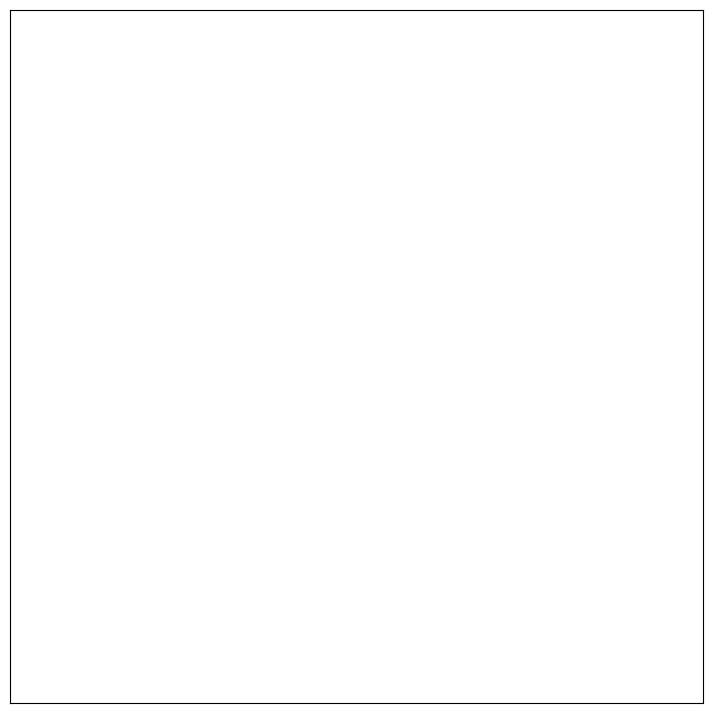

In [8]:
# simulation settings
delta_t = 0.05 # [sec]
sim_steps = 150 # [steps]
print(f"[INFO] delta_t : {delta_t:.2f}[s] , sim_steps : {sim_steps}[steps], total_sim_time : {delta_t*sim_steps:.2f}[s]")

# initialize a pendulum as a control target
pendulum = Pendulum(
    mass_of_pole = 1.0,
    length_of_pole = 1.0,
    max_torque_abs = 2.0,
    max_speed_abs = 8.0,
    delta_t = delta_t,
    visualize = True,
)
pendulum.reset(
    init_state = np.array([np.pi, 0.0]), # [theta(rad), theta_dot(rad/s)]
)

# initialize a mppi controller for the pendulum
mppi = MPPIControllerForPendulum(
    delta_t = delta_t,
    mass_of_pole = 1.0,
    length_of_pole = 1.0,
    max_torque_abs = 2.0,
    max_speed_abs = 8.0,
    horizon_step_T = 20,
    number_of_samples_K = 2000,
    param_exploration = 0.05,
    param_lambda = 0.5,
    param_alpha = 0.8,
    sigma = 1.0,
    stage_cost_weight    = np.array([1.0, 0.1]), # weight for [theta, theta_dot]
    terminal_cost_weight = 5.0 * np.array([1.0, 0.1]), # weight for [theta, theta_dot]
)

# simulation loop
for i in range(sim_steps):

    # get current state of pendulum
    current_state = pendulum.get_state()

    # calculate input force with MPPI
    input_torque, input_torque_sequence = mppi.calc_control_input(
        observed_x = current_state
    )

    # print current state and input torque
    print(f"Time: {i*delta_t:>2.2f}[s], theta={current_state[0]:>+3.3f}[rad], theta_dot={current_state[1]:>+3.3f}[rad/s], input torque={input_torque:>+3.2f}[Nm]", end="")
    print(", # currently staying upright #" if abs(current_state[0]) < 0.1 and abs(current_state[1] < 0.1) else "")

    # update states of pendulum
    pendulum.update(u=[input_torque], delta_t=delta_t)

# show animation
pendulum.show_animation(interval_ms=int(delta_t * 1000))
# save animation
pendulum.save_animation("mppi_pendulum.mp4", interval=int(delta_t * 1000), movie_writer="ffmpeg") # ffmpeg is required to write mp4 file